In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower'
})
from matplotlib.colors import LogNorm

import numpy as np
from scoobpy import utils
from magpyx.utils import ImageStream
from magpyx import instrument
from purepyindi import INDIClient
from time import sleep

# Using the Gromit Polarimeter

Welcome to the Gromit Polarimeter docs. These notebooks will walk you through how to take a Mueller Matrix measurement using a dual-rotating-retarder Mueller Polarimeter (DRRMP). If you'd like a primer on the theory behind the DRRMP, one is available on the [katsu documentation](https://katsu.readthedocs.io/en/latest/notebooks/FullMuellerExample.html).

First, let's start by setting up MuellerCam so that we can see light on the detector

## Set Up MuellerCam Exposure Time

In [3]:
# INDIClient let's us talk to hardware
client = INDIClient('localhost', 7624)
client.start()
sleep(1)

In [4]:
# Get the exposure time
exptime = client['muellercam.exptime.current'] # query
print(exptime, 's')

4.99999987368938e-05 s


In [114]:
# Set the exposure time
client['muellercam.exptime.target'] = 0.00005

## Set up Mueller Cam

In [5]:
# load the camera Image Stream
cam = ImageStream('muellercam')

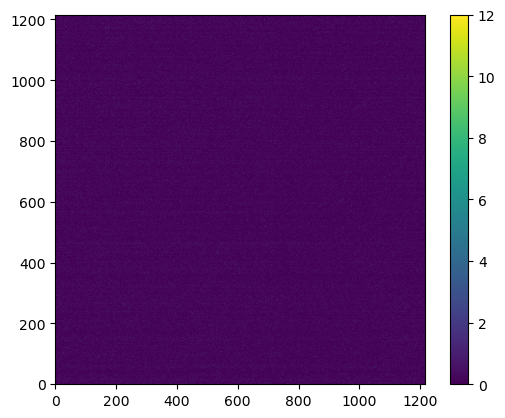

In [6]:
# Test image acquisition
im = cam.grab_latest()
plt.figure()
plt.imshow(im)
plt.colorbar()
plt.show()

## Configure the Nominal Polarizer Configuration

**Begin** by turning on your light source (users choice). Next, you want to mount the two fixed polarizers between the source and detector. Consider the ascii art:

```
---- Source ---- PSG/Pol --- Air --- PSA/Pol --- Detector --->
```

Where `PSG` is the polarization state generator and `PSA` is the polarization state analyzer. The starting state of the polarizers in each of these components does not, in principle, matter at all. So, it is convenient to fix the `PSG/Pol` and then set the `PSA/Pol` such that you are at a null. Then we at least know that the `PSA` is set to $90^{\circ}$ from the `PSG/Pol`.

To find the actual angle that we will use for the DRRMP calibration, we need to define a coordinate system. Consider the image of the Gromit polarimeter below where the principal axes are shown in yellow.

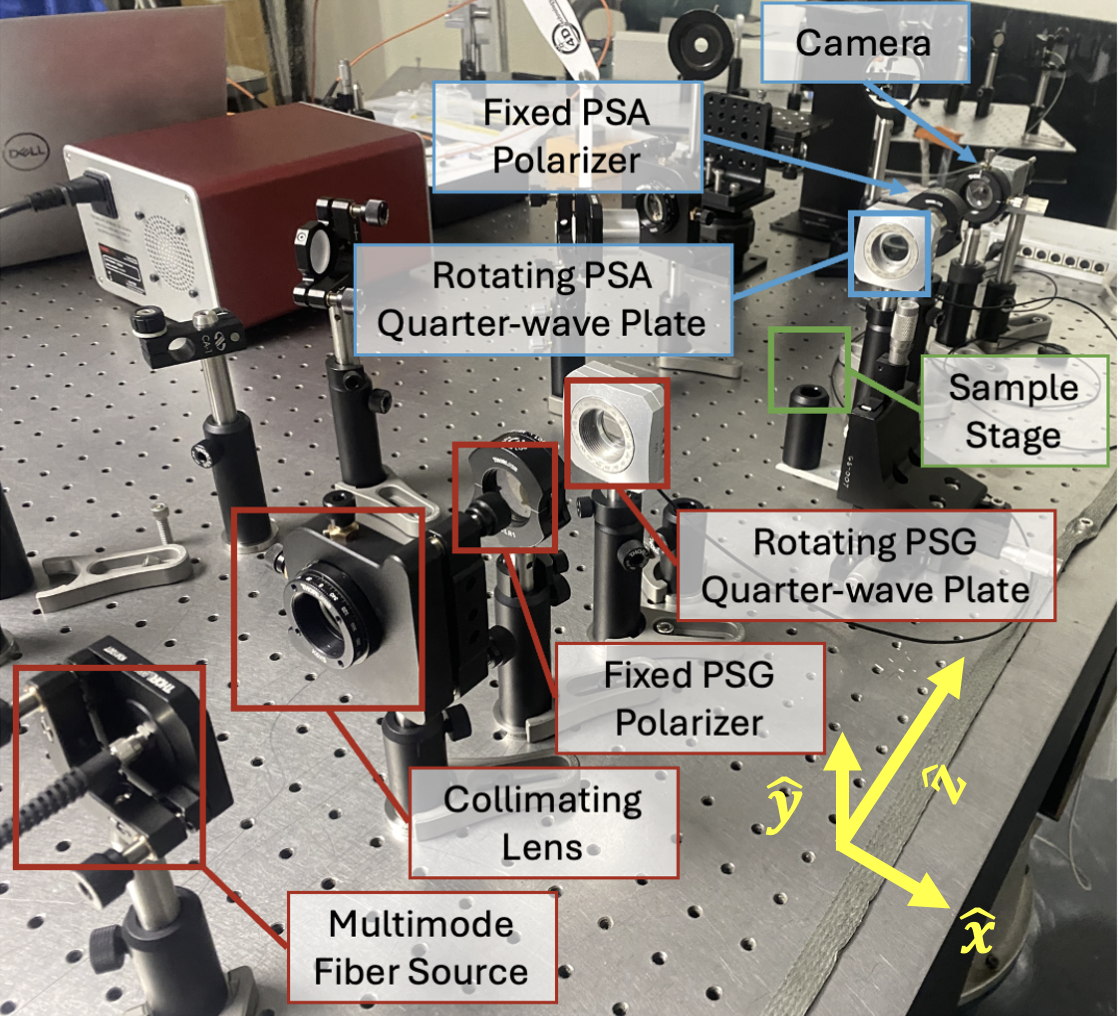

We define $\hat{x}$ as the "Horizontal" direction where $\theta=0^{\circ}$. Positive angles go from $+\hat{x}$ to $+\hat{y}$. Note the starting positions of the `PSG/Pol` and `PSA/Pol` in this coordinate system. 

**Next**, introduce the `PSG/QWP` to the beampath and rotate it by hand until the image on the sensor / card in front of sensor returns to a null. Note the orientation of the nominal fast axis, as indicated by a marker on the edge of the QWP.

**Repeat** this process for the `PSA/QWP`, noting the position of the nominal fast axis.

## Set up Rotation Stages

Now it's time to actually take the calibration measurement. We'll start with setting up the interface for the rotation stages from `katsu.motion`. Refer to the `katsu` docs for the full API reference.

In [117]:
from katsu.motion import AgilisRotationStage

For convenience we have this little bash script that prints the port that the Agilis controller is on.

In [8]:
! ./printusb.sh

{'name': '/dev/ttyUSB0', 'id_serial': 'Newport_Agilis_FT7WDD96'}


This shows how to use the Agilis Rotation Stage interface. Typically you just need to set the port, channel, and axis. The default baudrate is set to the Agilis Rotation Stage, but there are other parameters that can change.

In [120]:
ag1 = AgilisRotationStage(port='/dev/ttyUSB0', # USB Port
                          channel=1, axis=1)   # Channel + Axis it is plugged into
ag2 = AgilisRotationStage(port='/dev/ttyUSB0',
                          channel=1, axis=2)

In [121]:
# Enable remote mode so that commands can be sent
ag1.set_mode_remote()
sleep(1)
ag2.set_mode_remote()

In [122]:
# Empirically measured step size for a step amplitude of 50
ag1.angular_step_size = 0.0018926955621074413 # deg
ag1.compute_angular_position()
ag1.angular_position

454.2469349057859

In [123]:
# Empirically measured step size for a step amplitude of 50
ag2.angular_step_size = 0.0020046552854748553 # deg
ag2.compute_angular_position()
ag2.angular_position

2405.5863425698262

In [124]:
# Zero current Position
ag1.zero_position()
sleep(1)
ag2.zero_position()

In [125]:
# Set step amplitude
ag1.set_step_amplitude(50)
sleep(1)
ag2.set_step_amplitude(50)

In [126]:
# Check step amplitude
step_ag1 = ag1.get_step_amplitude()
sleep(1)
step_ag2 = ag2.get_step_amplitude()
print('step AG1 = ',step_ag1)
print('step AG2 = ',step_ag2)

step AG1 =  b'1SU+50\r\n'
step AG2 =  b'2SU+50\r\n'


In [ ]:
# Set step delay - units of 10us
ag1.set_step_delay(1)
sleep(1)
ag2.set_step_delay(1)

In [127]:
step_ag1 = ag1.get_step_delay()
sleep(1)
step_ag2 = ag2.get_step_delay()
print('step delay AG1 = ',step_ag1)
print('step delay AG2 = ',step_ag2)

step delay AG1 =  b'1DL1\r\n'
step delay AG2 =  b'2DL1\r\n'


## Running the Calibration

In [129]:
NMEAS = 40 # how many measurements
SLEEPYTIME = 9 # s, for 5000x steps at an amplitude of 50
FUNDAMENTAL_STEP = 5000 # step units

## Running the Mueller Polarimetry Experiment

In [135]:
# define linear steps
psg_angles = np.arange(0, NMEAS * (FUNDAMENTAL_STEP + 1), FUNDAMENTAL_STEP) * ag1.angular_step_size
psa_angles = np.arange(0, NMEAS * (FUNDAMENTAL_STEP + 1), FUNDAMENTAL_STEP) * ag2.angular_step_size * 5

# prealloc image list
image_list = []
accumulated_steps_ag1 = 0
accumulated_steps_ag2 = 0
print(psg_angles)
print(psa_angles)

[  0.           9.46347781  18.92695562  28.39043343  37.85391124
  47.31738905  56.78086686  66.24434467  75.70782248  85.17130029
  94.63477811 104.09825592 113.56173373 123.02521154 132.48868935
 141.95216716 151.41564497 160.87912278 170.34260059 179.8060784
 189.26955621 198.73303402 208.19651183 217.65998964 227.12346745
 236.58694526 246.05042307 255.51390088 264.9773787  274.44085651
 283.90433432 293.36781213 302.83128994 312.29476775 321.75824556
 331.22172337 340.68520118 350.14867899 359.6121568  369.07563461
 378.53911242]
[   0.           50.11638214  100.23276427  150.34914641  200.46552855
  250.58191068  300.69829282  350.81467496  400.93105709  451.04743923
  501.16382137  551.28020351  601.39658564  651.51296778  701.62934992
  751.74573205  801.86211419  851.97849633  902.09487846  952.2112606
 1002.32764274 1052.44402487 1102.56040701 1152.67678915 1202.79317128
 1252.90955342 1303.02593556 1353.1423177  1403.25869983 1453.37508197
 1503.49146411 1553.60784624 1603

## The Measurement Cell
This takes about 45mins to run

In [137]:
# this should take about half an hour
for i, (psat, psgt) in enumerate(zip(psa_angles, psg_angles)):
    
    # First measurement requires no motion
    if i == 0: 
        image_list.append(cam.grab_latest())
        sleep(1)
    else:
    
        # first move the PSG stage (ag1)
        ag1.relative_move(FUNDAMENTAL_STEP)
        accumulated_steps_ag1 += FUNDAMENTAL_STEP
        sleep(SLEEPYTIME)

        # second move the PSA stage (ag2)
        # Do this in increments of the same step size so that the same voltage is applied
        for _ in range(5):
            ag2.relative_move(FUNDAMENTAL_STEP)
            sleep(SLEEPYTIME)
        accumulated_steps_ag2 += FUNDAMENTAL_STEP*5

        # third take an image of it
        image_list.append(cam.grab_latest())
        sleep(1)
    
    print(f'iteration {i+1}/{NMEAS} completed')

iteration 1/40 completed
iteration 2/40 completed
iteration 3/40 completed
iteration 4/40 completed
iteration 5/40 completed
iteration 6/40 completed
iteration 7/40 completed
iteration 8/40 completed
iteration 9/40 completed
iteration 10/40 completed
iteration 11/40 completed
iteration 12/40 completed
iteration 13/40 completed
iteration 14/40 completed
iteration 15/40 completed
iteration 16/40 completed
iteration 17/40 completed
iteration 18/40 completed
iteration 19/40 completed
iteration 20/40 completed
iteration 21/40 completed
iteration 22/40 completed
iteration 23/40 completed
iteration 24/40 completed
iteration 25/40 completed
iteration 26/40 completed
iteration 27/40 completed
iteration 28/40 completed
iteration 29/40 completed
iteration 30/40 completed
iteration 31/40 completed
iteration 32/40 completed
iteration 33/40 completed
iteration 34/40 completed
iteration 35/40 completed
iteration 36/40 completed
iteration 37/40 completed
iteration 38/40 completed
iteration 39/40 compl

## Now Save the Measurement Data
At minimum, save the `image_list` data. Next we will hop over to another notebook to learn about how to calibrate the position and retardance of the `PSG` and `PSA`.

In [138]:
# Save the measurement results
# np.save('20240419_Mueller_Air_Calibration_01.npy', image_list)
# np.save('20240419_Mueller_Polarizer_Measurement_01.npy',image_list)
# np.save('20240419_Mueller_Air_Calibration_psa_angles_01.npy',psa_angles)
# np.save('20240419_Mueller_Air_Calibration_psg_angles_01.npy',psg_angles)
# image_list = np.load('20240410_Mueller_Air_Measurement_01.npy')

## useful commands
```
# Restart MuellerCam
su xsup
xctrl restart muellercam

# Check Jupyter server
systemctl jupyternotebook status

# Restart Jupyter server
sudo systemctl restart jupyternotebook
```
